
# Example - 1 : Diffusion Equation
- Partial Differential Equation: A 2-dimensional diffusion equation is given by: 

    \begin{align*}
    \frac{\partial T(x, y, t)}{\partial t} = \mathcal{D} \Bigl(\frac{\partial^2 T(x, y, t)}{\partial x^2} + \frac{\partial^2 T(x, y, t)}{\partial y^2}\Bigr) + \mathcal{S}(x, y, t), 
    \end{align*}
    
    where T is the variable of interest (concentration of species or temperature), $\mathcal{D}$ is diffusivity, and $\mathcal{S}$ is the source term.

- Discretization: We choose a uniform grid in space, and the Laplacian operator is discretized with second-order finite differences at each grid point $(i, j)$ as

    \begin{align*}
    (\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2})\big|_{i,j} \approx \frac{T_{i+1, j} + T_{i-1, j} + T_{i, j+1} + T_{i, j-1} - 4T_{i, j}}{h^2}.
    \end{align*}

- Input to the system: Heat is injected into the system via the source term which is obtained by interpolating the function

    \begin{equation*}
        \mathcal{S}(x, y, t) = 100 \exp{\Bigl( -0.8\bigl((x-l/2)^2 +(y-l/2)^2)\bigr)\Bigr)}\delta(t-0.2), 
    \end{equation*}
    where $\delta$ is the discrete-time unit impulse. We use a piecewise linear interpolation to obtain the source term as a continuous-time function $\mathcal{S}(x, y, t)$.

- LTI system: Semi-discretized diffusion equation is an LTI system 

    \begin{align*}
        x'(t) &= Ax(t) + Bu(t),\\
        y(t)  &= Cx(t) + Du(t).
    \end{align*}

- The key take-aways of this notebook:
    - If the state matrix $A$ is normal (AA* = A*A), it is Unitarily diagonalizable. For the chosen discretization, A is symmetric, and hence, normal. The Schur decomposition completely decouples all states in this case.
    - The computed dynamic neural network consists of a single vertical layer (each horizontal layer with exactly one neuron). 
    - We show that the dynamic neural network accurately simulates this system as compared to a numerical solver.


In [12]:
# Import packages
import numpy as np
from pandas.plotting import register_matplotlib_converters
import sys
sys.path.insert(0, "../../")
register_matplotlib_converters()

# Import modules from dynamic neural network
from dynamic_neural_networks.utils import *
from dynamic_neural_networks.transformations.helper_functions import *
from dynamic_neural_networks.transformations.sorted_real_schur_forms import *
from dynamic_neural_networks.model.dnn import *
from dynamic_neural_networks.model.state_space_model import *
from dynamic_neural_networks.utils.helper_functions import *
from dynamic_neural_networks.data.diffusion_equation_2d import *

expensive_asserts = False

Problem Setup

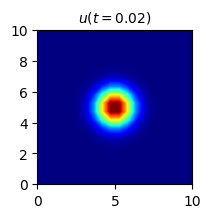

In [13]:
# Problem setup
# Dimensions of the LTI system
d_in = 400  # Input dimension  (<-> Source term: Heat source/sink at grid points)
d_state = 400  # State dimension  (<-> Temperature)
d_out = 400  # Output dimension (<-> Temperature (state = output))
ssm_dim = [d_state, d_in, d_out]  # Dimensions of the state-space model

# Spacial discretization
l_x = l_y = 10.0  # Domain lengths in two dimensions
nx = 20  # Number of grid points in the first dimension
ny = 20  # Number of grid points in the second dimension
h = l_x / (nx)  # Spacing between consecutive grid points on the uniform grid

# Constants
diffusivity = 0.8

# Get state-space matrices for this example
A, B, C, D = get_ssm(ssm_dim, nx, ny, h, diffusivity)
ssm = state_space_model(A, B, C, D)

# Timesteps
t_0 = 0.0  # Initial time
t_end = 10 #10.0  # Final time
dt = 0.1  # Determines the input-signal sampling frequency
timesteps = np.arange(t_0, t_end + dt, dt)  # All time-steps

# Method to interpolate the input function within each time-step
u_interp = "piecewise_linear"  # 'piecewise_constant', 'piecewise_linear', 'sample'

# Set u(t): Forcing term (Heat source/sink) over the grid as a function of time
inputs = get_input(l_x, nx, ny, timesteps, d_in, show_input=True)

# Ignore the following lines unless u_interp == 'sample'
if u_interp == "sample":
    t = timesteps
    i = np.arange(0, d_in, 1)
    u = inputs[0]
    u = u(np.reshape(t, (len(t), 1)), np.reshape(i, (1, len(i))))

In [14]:
# Dynamic Neural Network Parameters
n_clusters = 400  # Number of clusters of close eigenvalues
outer_loop = "neurons"  # 'neurons', 'timesteps'
ode_solver_rel_tol = 1e-10  # relative tolerance for ODE solver
ode_solver_abs_tol = 1e-10  # absolute tolerance for ODE solver
clustering_alg = KMeans(
    n_clusters=n_clusters, random_state=0, n_init="auto"
)  # Clustering algorithm
params = forward_pass_parameters(
    outer_loop=outer_loop,
    ssm_input_interpolation=u_interp,
    solver_routine="solve_ivp",
    ode_solver_params=ode_solver_parameters(
        atol=ode_solver_abs_tol, rtol=ode_solver_rel_tol, ode_solver="DOP853"
    ),
)  # Parameters concerning forward pass of a DyNN

In [2]:
# Initialize the dynamic neural network
dynn = dynamic_neural_network(ssm=ssm)

# Simulate the LTI system using a dynamic neural network
dynn.fit(clustering_alg, verbose=0, show_plots=True)

# Condition number of the transformation matrix
print("Condition number of the transformation matrix = ", dynn.cond_num)

# Plot eigenvalue clusters and DyNN architecture
dynn.plot_architecture(figname="diffusion", fig_size_1=(3, 2), fig_size_2=(2.5, 2), fontsize = 12, color_bar=True, sort_evals=True)

NameError: name 'dynamic_neural_network' is not defined

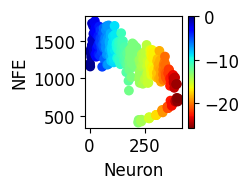

In [16]:
# Perform forward pass and compute output
y_dynn = dynn.predict(inputs, timesteps, params)

# Plot: Avg number of function evaluations in each horizontal layer.
dynn.plot_NFE(figname="diffusion", fig_size=(2.5, 2), fontsize=12, x_label='Neuron', y_label="NFE", color_bar=True, sort_evals=True)

In [17]:
# Simulate the LTI system using python routine lsim
y_lsim = numerical_simulation_lsim(timesteps, inputs[0], ssm, interp=True)

# Simulate the LTI system using python routine solve_ivp
y_solve_ivp, nfe_solver = numerical_simulation_ivp_solve(
    ssm,
    inputs,
    timesteps,
    u_interp,
    outer_loop,
    rtol=ode_solver_rel_tol,
    atol=ode_solver_abs_tol,
)

Compare the simulation results

In [18]:
# Compute relative and absolute errors
abs_err_lsim = abs(y_dynn - y_lsim)
print("Max absolute error (DyNN and solver:lsim) :", np.amax(abs_err_lsim))

abs_err_solve_ivp = abs(y_dynn - y_solve_ivp)
print("Max absolute error (DyNN and solver:solve_ivp) :", np.amax(abs_err_solve_ivp))

abs_err_between_solvers = abs(y_lsim - y_solve_ivp)
print("Max absolute error between solvers :", np.amax(abs_err_between_solvers))

Max absolute error (DyNN and solver:lsim) : 1.460456111330649e-07
Max absolute error (DyNN and solver:solve_ivp) : 4.092401662547651e-07
Max absolute error between solvers : 4.080933985739499e-07


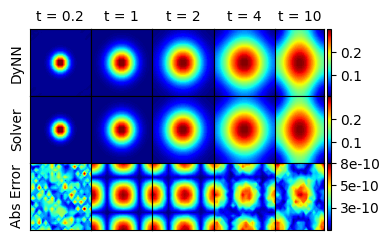

In [19]:
# Comparison of PDE solutions: (a) using the constructed dynamic neural
# network (DyNN), and (b) numerical solver along with the absolute errors.
compare_pde_solutions(
    timesteps, l_x, l_y, nx, ny, y_dynn, y_lsim, fig_size=(4, 2.5), save_fig=True, figname='diff_sol_err.pdf', fontsize = 12
)

In [20]:
# Print other information:
# Largest magnitude of eigenvalue
print('Largest magnitude of eigenvalue: ', max(abs(dynn.eigenvalues)))

# Comparison of number of function evaluations: 
# (a) Neuron with max NFE count (reqires evaluations of the 1 * 1 diagonal block of the state matrix)
# (b) NFE count of the original LTI system (requires evaluation of the entire state matrix)
nfe_neuron_max = np.zeros(len(dynn.dynn_blocks))
for i in range(len(dynn.dynn_blocks)):
    nfe_neuron_max[i] = dynn.dynn_blocks[i].rhs_evaluations

print('NFE count of the original LTI system', nfe_solver)
print('NFE count of the neuron with the highest NFEs: ', int(max(nfe_neuron_max)))


Largest magnitude of eigenvalue:  25.60000000000006
NFE count of the original LTI system 1739
NFE count of the neuron with the highest NFEs:  1757


C:\Users\Bryan Rodriguez\AppData\Local\Temp\ipykernel_8844\3317460490.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nfe_neuron_max[i] = dynn.dynn_blocks[i].rhs_evaluations
